# CoxKAN Introductory Demo

In [4]:
from coxkan import CoxKAN
from sklearn.model_selection import train_test_split
import numpy as np

### Synthetic Dataset Example

The code below generates a synthetic survival dataset under the hazard function

$$\text{Hazard, } h(t, \mathbf{x}) = 0.01 e^{\theta(\mathbf{x})},$$

where

$$\text{Log-Partial Hazard, }\theta (\mathbf{x}) = \tanh (5x_1) + \sin (2 \pi x_2)$$

and a **uniform censoring distribution**.

In [5]:
from coxkan.datasets import create_dataset

log_partial_hazard = lambda x1, x2: np.tanh(5*x1) + np.sin(2*np.pi*x2)

df = create_dataset(log_partial_hazard, baseline_hazard=0.01, n_samples=10000, seed=42)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train.head()

Concordance index of true expression: 0.7524


,x1,x2,duration,event
9254,0.541629,-0.706251,42.270669,1
1561,-0.526259,-0.492606,54.283488,1
1670,-0.238753,-0.326589,361.569903,1
6087,-0.588024,0.742029,57.335278,0
6669,-0.739364,-0.302907,95.975668,1


Train CoxKAN:

train loss: 2.77e+00 | val loss: 2.50e+00: 100%|██████████████████| 100/100 [00:06<00:00, 15.48it/s]



CoxKAN C-Index:  0.7553786667818724


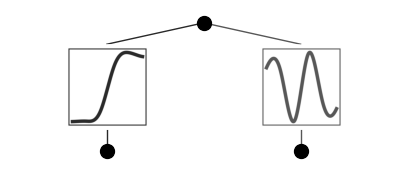

In [6]:
ckan = CoxKAN(width=[2,1], grid=5, seed=42)

_ = ckan.train(
    df_train, 
    df_test, 
    duration_col='duration', 
    event_col='event',
    opt='Adam',
    lr=0.01,
    steps=100)

# evaluate CoxKAN
cindex = ckan.cindex(df_test)
print("\nCoxKAN C-Index: ", cindex)

# plot CoxKAN
fig = ckan.plot()

Symbolic Fitting:

In [7]:
# auto-symbolic fitting
_ = ckan.auto_symbolic(lib=['x^2', 'sin', 'exp', 'log', 'sqrt', 'tanh'], verbose=False)

# train affine parameters
_ = ckan.train(df_train, df_test, duration_col='duration', event_col='event', opt='LBFGS', steps=10)

display(ckan.symbolic_formula(floating_digit=1)[0][0])

train loss: 2.77e+00 | val loss: 2.50e+00: 100%|████████████████████| 10/10 [00:01<00:00,  8.19it/s]


-1.0*sin(6.3*x2 + 9.4) + 1.0*tanh(4.4*x1)

We see CoxKAN approximately recovers the true log-partial hazard:

$\hat{\theta}_{KAN} = \tanh(4.4 x_1) -\sin(6.3 x_2 + 9.4) \approx \tanh(5 x_1) -\sin(2 \pi x_2 + 3 \pi) = \tanh(5 x_1)+ \sin(2 \pi x_2)$

### Real dataset example

Using default train-test split (used in DeepSurv paper).


train loss: 2.60e+00 | val loss: 2.41e+00: 100%|██████████████████| 100/100 [00:01<00:00, 55.04it/s]



CoxKAN C-Index:  0.6798424912829145


Piecewise((0.06, Eq(meno, 0)), (0.22, Eq(meno, 1.0)), (nan, True)) + Piecewise((0.23, Eq(hormon, 0)), (-0.11, Eq(hormon, 1.0)), (nan, True)) + Piecewise((-0.16, Eq(size, 0)), (0.09, Eq(size, 1.0)), (0.36, Eq(size, 2.0)), (nan, True)) + 0.759 - 1.16*exp(-0.03*(-nodes - 0.58)**2) - 0.32*exp(-5.59*(0.02*age - 1)**2)

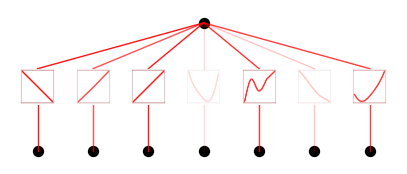

In [8]:
from coxkan.datasets import gbsg

# load dataset
df_train, df_test = gbsg.load(split=True)
name, duration_col, event_col, covariates = gbsg.metadata()

# init CoxKAN
ckan = CoxKAN(width=[len(covariates), 1], seed=42)

# pre-process and register data
df_train, df_test = ckan.process_data(df_train, df_test, duration_col, event_col, normalization='standard')

# train CoxKAN
_ = ckan.train(
    df_train, 
    df_test, 
    duration_col=duration_col, 
    event_col=event_col,
    opt='Adam',
    lr=0.01,
    steps=100)

print("\nCoxKAN C-Index: ", ckan.cindex(df_test))

# Auto symbolic fitting
fit_success = ckan.auto_symbolic(verbose=False)
display(ckan.symbolic_formula(floating_digit=2)[0][0])

# Plot coxkan
fig = ckan.plot(beta=20)